In [8]:
import cv2
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from pathlib import Path


/Users/jbalkovec/Desktop/DR/XMLparser


In [2]:
# Old code...

image_path = Path("diaretdb1_image005.png")
xml_path = Path("diaretdb1_image005_01.xml")

image = cv2.imread(str(image_path))
if image is None:
    raise ValueError(" :( ")
green_channel = image[:, :, 1]  # green channel

tree = ET.parse(xml_path)
root = tree.getroot()


[ WARN:0@3.215] global loadsave.cpp:268 findDecoder imread_('diaretdb1_image005.png'): can't open/read file: check file path/integrity


ValueError:  :( 

In [21]:
# store each lesion's center/type
lesion_data = []
for mark in root.findall(".//marking"):
    lesion_type = mark.findtext("markingtype")
    center_elem = mark.find(".//centroid/coords2d")
    if center_elem is not None:
        cx, cy = map(int, center_elem.text.split(','))
        lesion_data.append((cx, cy, lesion_type))#saves for patch extraction


In [22]:
# extract 25x25 patches centered on lesions
patches = []
labels = []
coords = []
patch_size = 25
half = patch_size // 2 #to center patch

for cx, cy, lesion_type in lesion_data:
    x1, x2 = cx - half, cx + half + 1
    y1, y2 = cy - half, cy + half + 1

    # makes sure patch is actually inside the image
    if x1 >= 0 and y1 >= 0 and x2 <= green_channel.shape[1] and y2 <= green_channel.shape[0]:
        patch = green_channel[y1:y2, x1:x2]
        if patch.shape == (25, 25):
            patches.append(patch)
            labels.append(lesion_type)
            coords.append((cx, cy))


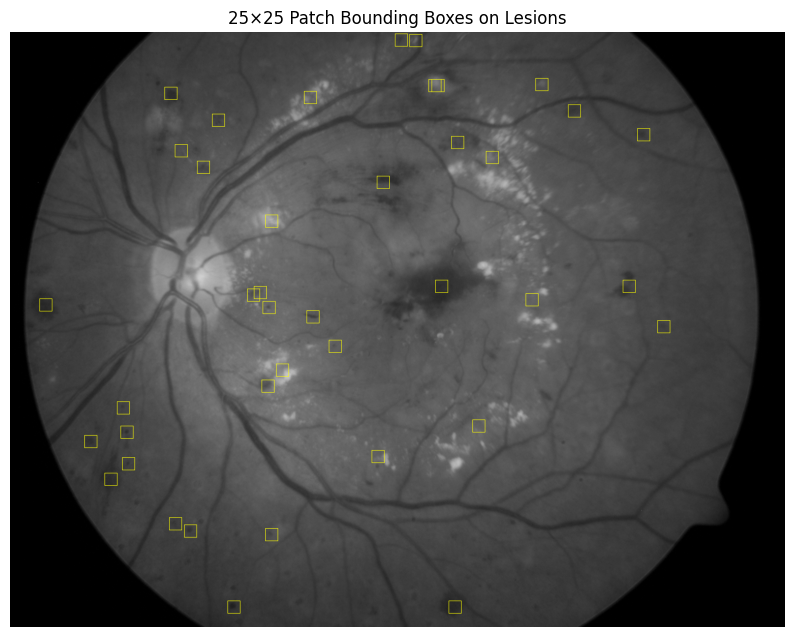

In [23]:
# draw boxes of patches, visualization of each lesion center
debug_image = cv2.cvtColor(green_channel, cv2.COLOR_GRAY2BGR)
for cx, cy in coords:
    top_left = (cx - half, cy - half)
    bottom_right = (cx + half, cy + half)
    cv2.rectangle(debug_image, top_left, bottom_right, (0, 255, 255), 1)

# put patch locations over image
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(debug_image, cv2.COLOR_BGR2RGB))
plt.title("25×25 Patch Bounding Boxes on Lesions")
plt.axis("off")
plt.show()


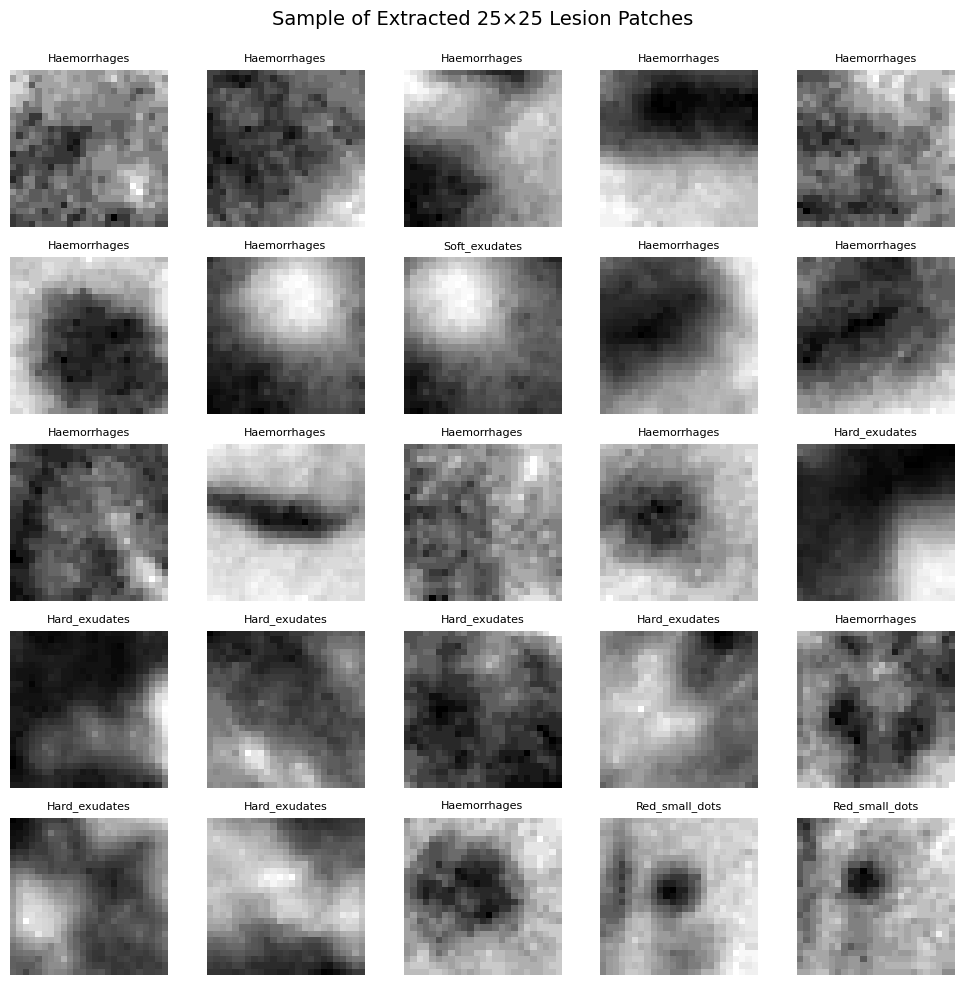

In [24]:
# show grid of patches with lesion types
def plot_patch_grid(patches, labels, grid_size=5):
    n = min(len(patches), grid_size**2)
    plt.figure(figsize=(10, 10))
    for i in range(n):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(patches[i], cmap='gray')
        plt.title(labels[i], fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.suptitle("Sample of Extracted 25×25 Lesion Patches", fontsize=14)
    plt.subplots_adjust(top=0.92)
    plt.show()

plot_patch_grid(patches, labels)


In [25]:
# show all patches of one lesion type
def plot_by_class(patches, labels, target_class, grid_size=5):
    #filter for only patches that match lesion type
    selected = [(p, l) for p, l in zip(patches, labels) if l == target_class]
    n = min(len(selected), grid_size**2)
    if n == 0:
        print(f"No patches found: {target_class}")
        return

    plt.figure(figsize=(10, 10))
    for i in range(n):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(selected[i][0], cmap='gray')
        plt.title(target_class, fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.suptitle(f"{target_class} Patches", fontsize=14)
    plt.subplots_adjust(top=0.92)
    plt.show()


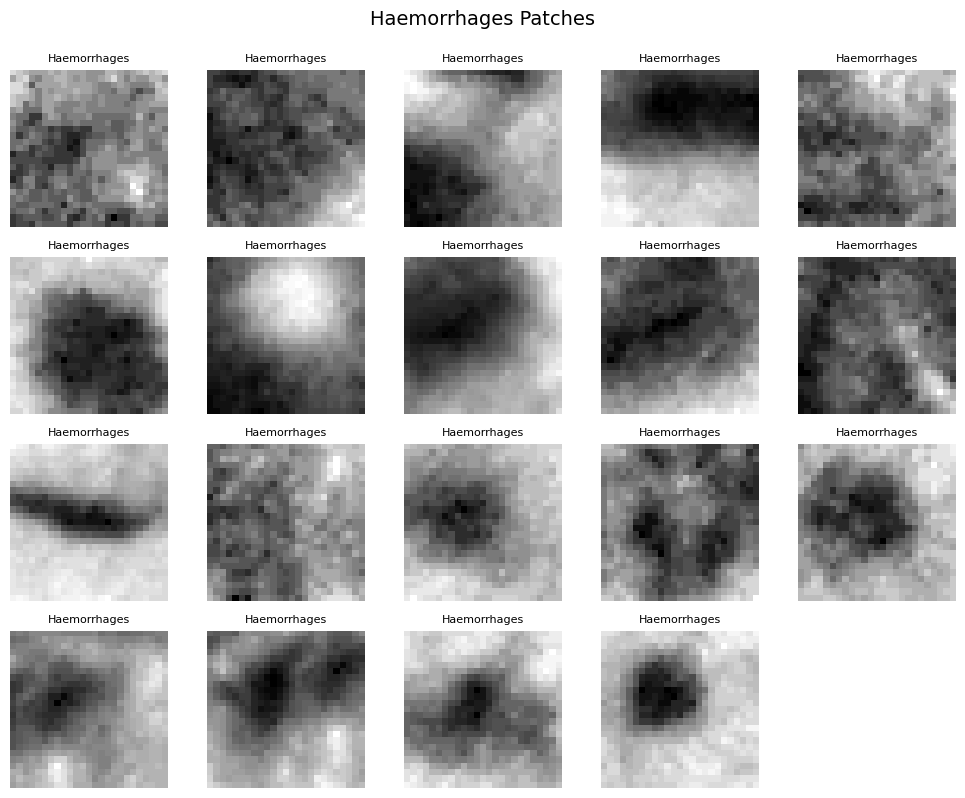

,lesion_type,count
0,Haemorrhages,19
1,Red_small_dots,11
2,Hard_exudates,9
3,Soft_exudates,1


In [26]:
# test:find all haemorrhages
plot_by_class(patches, labels, target_class="Haemorrhages")

# count for all types
df = pd.DataFrame(labels, columns=["lesion_type"])
df.value_counts().reset_index(name='count')
